<a href="https://colab.research.google.com/github/jimgoo/medical/blob/main/stylegan_recon_colab_v0.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paul Scotti 2022

In [1]:
!nvidia-smi

Thu Oct 27 15:46:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:             25           0           9           0          14          24
Swap:             0           0           0


In [3]:
ddir = './'
#ddir = '/content/drive/MyDrive/neuro'

if 'MyDrive' in ddir:
    from google.colab import drive
    drive_path = "/content/drive"
    drive.mount(drive_path)

In [5]:
import os
files = ['subj01_nsdgeneral.hdf5', 'stylegan_projections.hdf5', 'COCO_73k_subj_indices.hdf5']
for f in files:
    if not os.path.exists(os.path.join(ddir, f)):
        !wget -c -P {ddir} https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/{f}

In [8]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# import lpips
# loss_fn = lpips.LPIPS(net='vgg').to(device)

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))

def torch_to_Image(x,device=device):
    if device=='cpu':
        return PIL.Image.fromarray((x.permute(0, 2, 3, 1)*127.5+128).clamp(0,255).to(torch.uint8).numpy()[0])
    else:
        return PIL.Image.fromarray((x.permute(0, 2, 3, 1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()[0])

def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5

def torch_to_matplotlib(x,device=device):
    if torch.mean(x)>10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]

cuda


In [9]:
torch.__version__

'1.12.1+cu113'

# Load Data

In [10]:
# Load data
subj = 'subj01' # 37 sessions (each session = 750 images)
train_trials = np.arange(750*37 - 200)
val_trials = np.arange(750*37 - 200, 750*37)

f = h5py.File(os.path.join(ddir, f'{subj}_nsdgeneral.hdf5'), 'r')
train_voxels = f['voxels'][train_trials]
val_voxels = f['voxels'][val_trials]
print("Voxels loaded.")

Voxels loaded.


In [11]:
f['voxels'].shape

(27750, 15724)

In [12]:
f['images'].shape

(27750, 256, 256, 3)

In [13]:
train_trials.shape, val_trials.shape

((27550,), (200,))

In [14]:
train_voxels.shape, val_voxels.shape

((27550, 15724), (200, 15724))

In [15]:
f = h5py.File(os.path.join(ddir, 'COCO_73k_subj_indices.hdf5'), 'r')
all_73KID = f[subj]

train_ind = all_73KID[train_trials]
_, train_ind_order = np.unique(train_ind, return_inverse=True)

val_ind = all_73KID[val_trials]
_, val_ind_order = np.unique(val_ind, return_inverse=True)

print("Trial indices loaded.")

Trial indices loaded.


In [16]:
all_73KID.shape

(27750,)

In [17]:
np.unique(all_73KID).shape

(9841,)

In [18]:
train_ind.shape, val_ind.shape

((27550,), (200,))

In [19]:
f = h5py.File(os.path.join(ddir, 'stylegan_projections.hdf5'), 'r')
train_embs = f['projections'][np.unique(np.sort(train_ind))]
val_embs = f['projections'][np.unique(np.sort(val_ind))]
train_embs = train_embs[train_ind_order]
val_embs = val_embs[val_ind_order]
print("Embeddings loaded.")

Embeddings loaded.


In [20]:
f['projections'].shape

(73000, 32, 512)

In [21]:
train_embs.shape, val_embs.shape

((27550, 32, 512), (200, 32, 512))

In [22]:
# ensuring no validation trials w/ images presented in training data
exclude_repeats = ~np.isin(val_ind, train_ind)

In [23]:
np.where(exclude_repeats)[0].shape

(40,)

In [24]:
val_voxels = val_voxels[exclude_repeats] 
val_embs = val_embs[exclude_repeats]

#del all_73KID # no longer needed
f.close() # close the hdf5 file

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)

assert len(train_voxels) == len(train_embs)
assert len(val_voxels) == len(val_embs)

(27550, 15724) (27550, 32, 512)
(40, 15724) (40, 32, 512)


In [25]:
len(val_voxels) / len(train_voxels)

0.0014519056261343012

# Create / Train Model

In [26]:
# set seeds to keep things reproducible and stay sane
torch.manual_seed(0)
np.random.seed(0)

# create network
input_size = 15724
h1 = 1024*3
voxels2emb = torch.nn.Sequential(
    torch.nn.BatchNorm1d(input_size),
    torch.nn.Linear(input_size, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15),  
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15), 
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.Linear(h1, 512*32),
).to(device)

mse = nn.MSELoss()
initial_learning_rate = .003 
# optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)
optimizer = torch.optim.SGD(voxels2emb.parameters(), lr=initial_learning_rate, momentum=0.95)
num_epochs = 50
batch_size = 32
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=3e-6, patience=5)

data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(train_voxels).to(device), 
                                                                                 torch.tensor(train_embs).to(device)),
                                                                    batch_size=batch_size, shuffle=True)

data_loader_val = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(val_voxels).to(device), 
                                                                                 torch.tensor(val_embs).to(device)),
                                                                    batch_size=len(val_voxels), shuffle=False)

In [27]:
train_losses = []; val_losses = []; lrs = [];
for epoch in tqdm(range(num_epochs)):
    voxels2emb.train()
    for i, (voxel, emb) in enumerate(data_loader):
        optimizer.zero_grad()
        
        emb_ = voxels2emb(voxel)
        emb_ = emb_.reshape(emb.shape)

        loss = mse(emb,emb_)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    voxels2emb.eval() # note: each validation loss is entire set, not actually batched
    for i, (val_voxel, val_emb) in enumerate(data_loader_val):
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
            val_emb_ = val_emb_.reshape(val_emb.shape)
            val_loss = mse(val_emb,val_emb_)
            val_losses.append(val_loss.item())
        
    # for ReduceLROnPlateau
    scheduler.step(val_loss)
    lrs.append(optimizer.param_groups[0]['lr'])

100%|██████████| 50/50 [24:18<00:00, 29.17s/it]


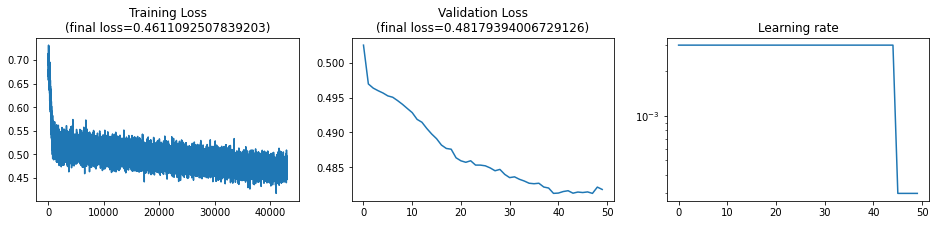

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
ax2.plot(val_losses)
ax3.set_title("Learning rate")
ax3.plot(lrs)
ax3.set_yscale('log')
plt.show()

In [30]:
lrs[-1]

0.00030000000000000003

In [39]:
# import sys
# sys.exit(0)

# Save/Load Model

In [33]:
# Saving
torch.save({
            'epoch': epoch,
            'model_state_dict': voxels2emb.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, 'voxels2emb.pth')

In [ ]:
# Loading 
checkpoint = torch.load('voxels2emb.pth')
voxels2emb.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Visualize reconstructions
Note: you may need to restart kernel, load the model you saved in the above cell, and then run the following cells

In [31]:
# Load StyleGAN-XL
!git clone https://github.com/autonomousvision/stylegan_xl
!wget https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 298 (delta 75), reused 80 (delta 53), pack-reused 192
Receiving objects: 100% (298/298), 13.89 MiB | 18.09 MiB/s, done.
Resolving deltas: 100% (134/134), done.
--2022-10-27 16:32:23--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.223
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1962430448 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet256.pkl’

imagenet256.pkl     100%[===================>]   1.83G  11.9MB/s    in 2m 44s  

2022-10-27 16:35:08 (11.4 MB/s) - ‘imagenet256.pkl’ saved [1962430448/1962430448]



In [34]:
sys.path.append('./stylegan_xl')
!pip install ninja
!pip install timm ftfy 
import dnnlib
import legacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 4.2 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 163 kB 68.8 MB/s 


In [35]:
# Load pretrained model
network_pkl = 'imagenet256.pkl'
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
print('Using device:', device, file=sys.stderr)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "imagenet256.pkl"...


Using device: cuda


In [36]:
# Load original presented images 
f = h5py.File(os.path.join(ddir, 'subj01_nsdgeneral.hdf5'), 'r')
# train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
val_images = val_images[exclude_repeats]
f.close()

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


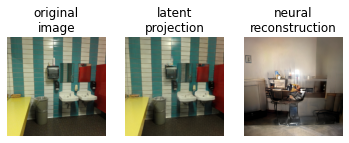

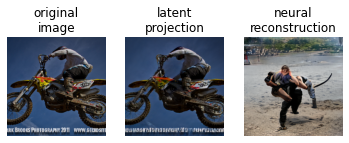

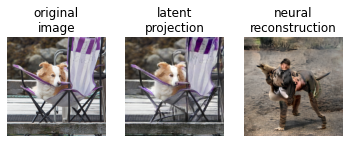

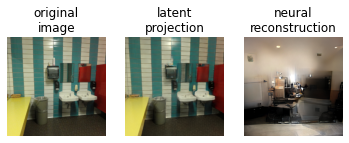

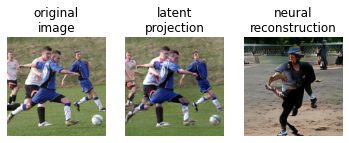

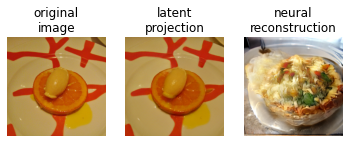

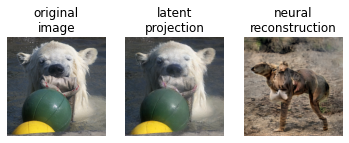

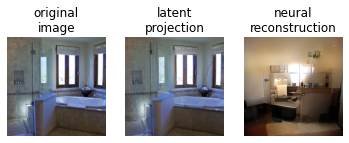

In [38]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()

with torch.no_grad():
    emb_ = voxels2emb(torch.tensor(val_voxels)[:8].to(device)).reshape([8,32,512])
    
    for i in range(8):
        pic = G.synthesis(torch.tensor(val_embs)[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")